In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [2]:
npart=4
nrand=4
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.ToyJetDataset(npart,nj_train,nj_valid,nj_testy,nrand=nrand)

xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 0
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent :

In [3]:
input_dim  = tjds.train_data.shape[1]
hidden_dims= [128,128,32,16]
embed_dim  = 4
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [03:14<00:00,  1.30s/it]


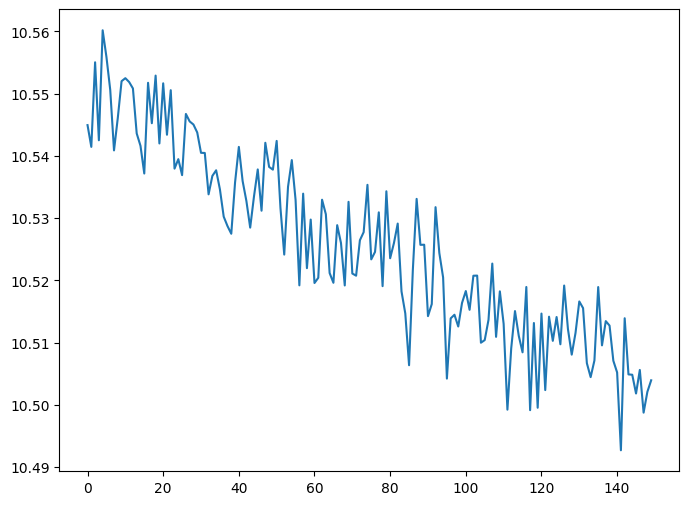

In [17]:
import data.data_utils as dutils
# Training loop
num_epochs = 150
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

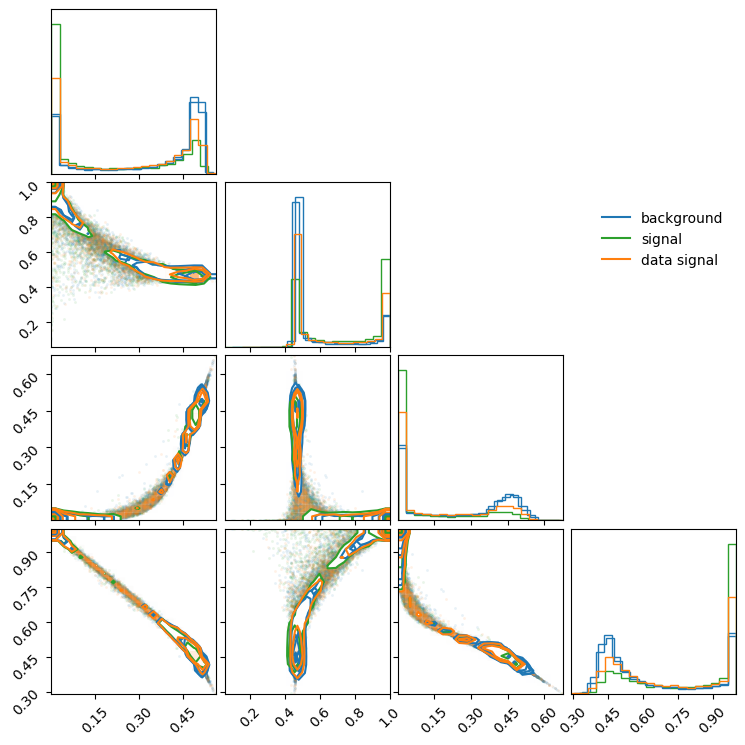

In [18]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True).numpy())
    output1 = (model(tjds.true_data.float(),embed=True).numpy())

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C2", label='signal')
corner.corner(output1[labels1==0],fig=fig,color="C0", label='background')
corner.corner(output1[labels1==1],fig=fig,color="C1", label='daa signal')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C2", label='signal'),
            mlines.Line2D([], [], color="C1", label='data signal'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.96it/s]


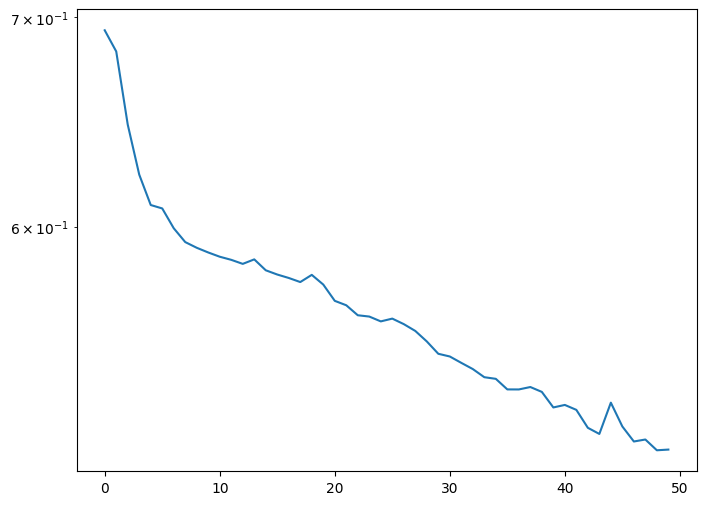

Accuracy: tensor(0.6884)


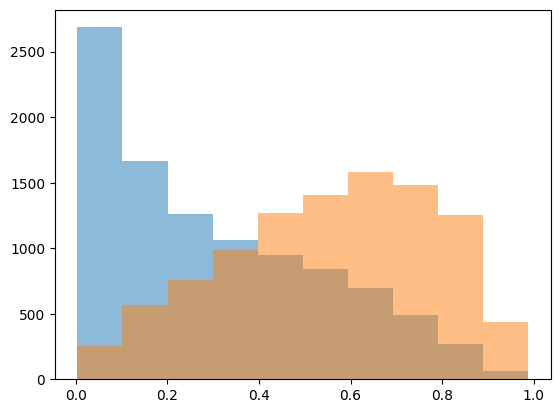

Accuracy: tensor(0.5834)


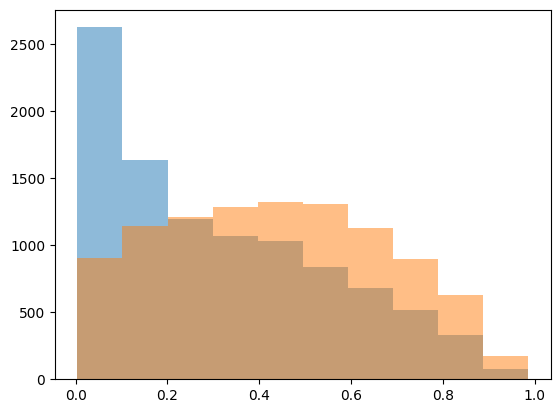

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.17it/s]


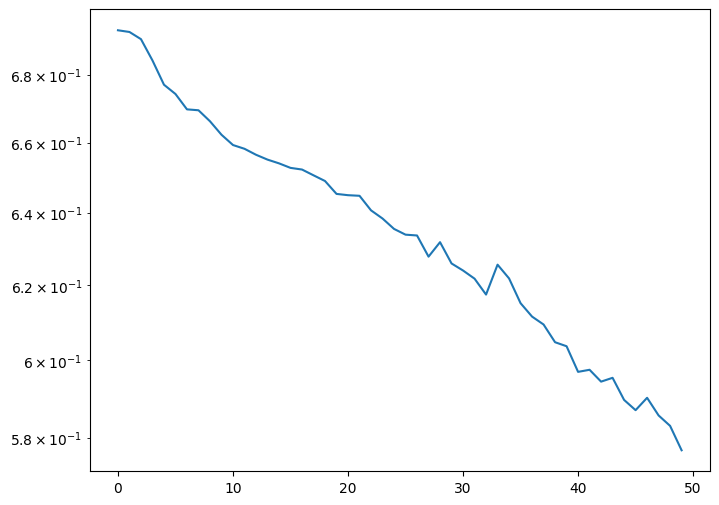

Accuracy: tensor(0.5856)


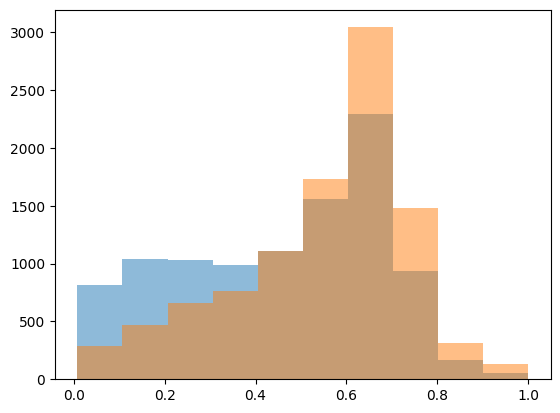

In [19]:
import data.data_utils as dutils
print(input_dim)
batch_size=2000
disc_trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model=dutils.train_disc(50,disc_trainloader,input_dim)
plt.show()
dutils.check_disc(tjds.test_data,tjds.test_labels,disc_model)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model)
plt.show()

disc_trainloader = torch.utils.data.DataLoader(tjds.true_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model=dutils.train_disc(50,disc_trainloader,input_dim)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.64it/s]


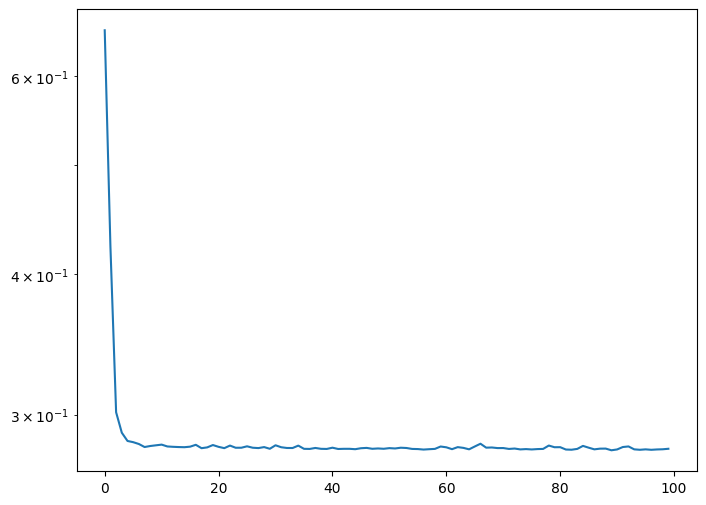

Accuracy: tensor(0.6645)


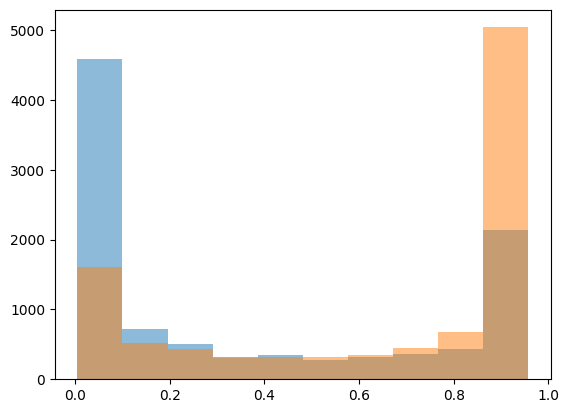

Accuracy: tensor(0.5801)


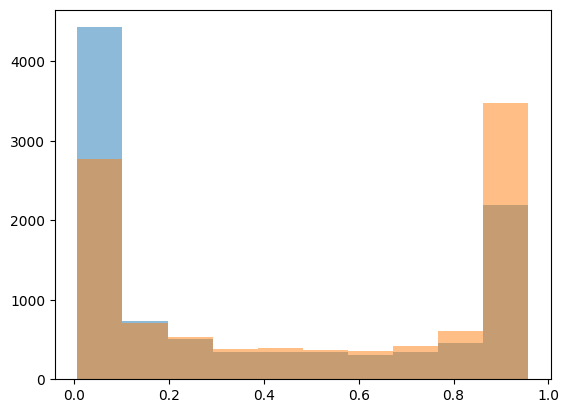

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


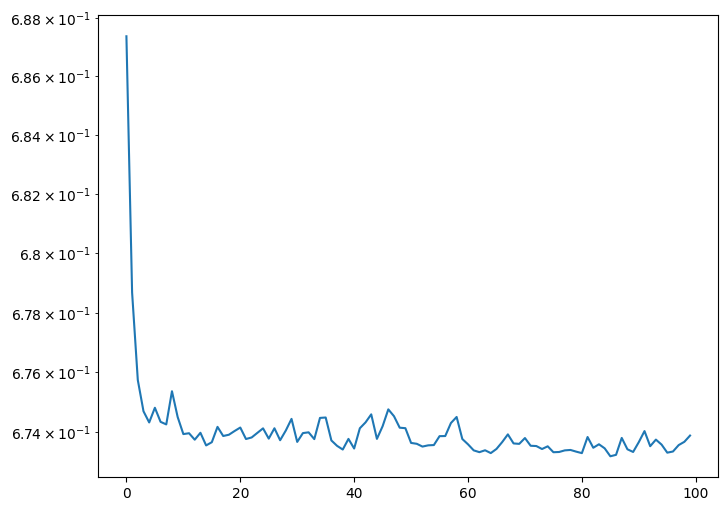

Accuracy: tensor(0.5836)


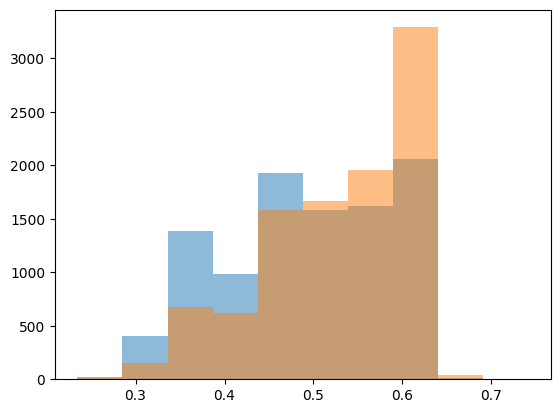

In [20]:
labels =tjds.test_labels
labels1=tjds.true_labels
with torch.no_grad():
    outputt  = (model(tjds.train_data.float(),embed=True))
    outputt1 = (model(tjds.true_data.float(),embed=True))
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.trut_data.float(),embed=True))

trainspace=dutils.GenericDataset(outputt,labels)
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=dutils.train_disc(100,trainloader,output.shape[1])
plt.show()
dutils.check_disc(output,tjds.test_labels,disc_model_ctr)
plt.show()
dutils.check_disc(output1,tjds.trut_labels,disc_model_ctr)
plt.show()


trainspace=dutils.GenericDataset(outputt1,labels1)
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=dutils.train_disc(100,trainloader,output1.shape[1])
plt.show()
dutils.check_disc(output1,tjds.trut_labels,disc_model_ctr)
plt.show()


In [6]:
print(tjds.train_data[0].reshape(4,3))
#indices = np.sort(tjds.train_data[0].reshape(8,3),axis=0)
indices=tjds.train_data[0].reshape(4,3).argsort(axis=0)[:,0]
print(indices)
tjds.train_data[0].reshape(4,3)[indices]

tensor([[ 0.0340, -0.1808, -0.1275],
        [ 0.2601,  0.1781, -0.0257],
        [ 0.3644,  0.1966,  0.0505],
        [ 0.8242, -0.1361, -0.0089]], dtype=torch.float64)
tensor([0, 1, 2, 3])


tensor([[ 0.0340, -0.1808, -0.1275],
        [ 0.2601,  0.1781, -0.0257],
        [ 0.3644,  0.1966,  0.0505],
        [ 0.8242, -0.1361, -0.0089]], dtype=torch.float64)

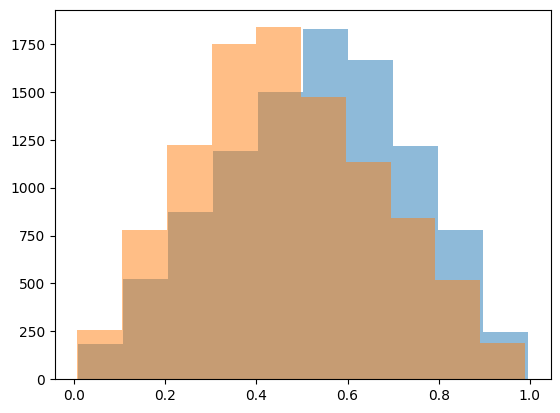

In [31]:
vals0=np.random.triangular(0.,0.6, 1, 10000)
vals1=np.random.triangular(0.,0.4, 1, 10000)
plt.hist(vals0,alpha=0.5)
plt.hist(vals1,alpha=0.5)
plt.show()